In [1]:
import math
import time
import sox

import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import librosa
import soundfile
import matplotlib.pyplot as plt  
import numpy as np
import pandas as pd
from IPython.display import Audio, display

In [3]:
DEFAULT_OFFSET = 201
SWEEP_MAX_SAMPLE_RATE = 48000
DEFAULT_LOWPASS_FILTER_WIDTH = 6
DEFAULT_ROLLOFF = 0.99
DEFAULT_RESAMPLING_METHOD = "sinc_interpolation"

In [4]:
def _get_log_freq(sample_rate, max_sweep_rate, offset):
    """Get freqs evenly spaced out in log-scale, between [0, max_sweep_rate // 2]

    offset is used to avoid negative infinity `log(offset + x)`.

    """
    start, stop = math.log(offset), math.log(offset + max_sweep_rate // 2)
    return torch.exp(torch.linspace(start, stop, sample_rate, dtype=torch.double)) - offset

In [6]:
def _get_inverse_log_freq(freq, sample_rate, offset):
    """Find the time where the given frequency is given by _get_log_freq"""
    half = sample_rate // 2
    return sample_rate * (math.log(1 + freq / offset) / math.log(1 + half / offset))

In [7]:
def _get_freq_ticks(sample_rate, offset, f_max):
    # Given the original sample rate used for generating the sweep,
    # find the x-axis value where the log-scale major frequency values fall in
    time, freq = [], []
    for exp in range(2, 5):
        for v in range(1, 10):
            f = v * 10 ** exp
            if f < sample_rate // 2:
                t = _get_inverse_log_freq(f, sample_rate, offset) / sample_rate
                time.append(t)
                freq.append(f)
    t_max = _get_inverse_log_freq(f_max, sample_rate, offset) / sample_rate
    time.append(t_max)
    freq.append(f_max)
    return time, freq

In [8]:
def get_sine_sweep(sample_rate, offset=DEFAULT_OFFSET):
    max_sweep_rate = sample_rate
    freq = _get_log_freq(sample_rate, max_sweep_rate, offset)
    delta = 2 * math.pi * freq / sample_rate
    cummulative = torch.cumsum(delta, dim=0)
    signal = torch.sin(cummulative).unsqueeze(dim=0)
    return signal

In [9]:
def plot_sweep(
    waveform,
    sample_rate,
    title,
    max_sweep_rate=SWEEP_MAX_SAMPLE_RATE,
    offset=DEFAULT_OFFSET,
):
    x_ticks = [100, 500, 1000, 5000, 10000, 20000, max_sweep_rate // 2]
    y_ticks = [1000, 5000, 10000, 20000, sample_rate // 2]

    time, freq = _get_freq_ticks(max_sweep_rate, offset, sample_rate // 2)
    freq_x = [f if f in x_ticks and f <= max_sweep_rate // 2 else None for f in freq]
    freq_y = [f for f in freq if f >= 1000 and f in y_ticks and f <= sample_rate // 2]

    figure, axis = plt.subplots(1, 1)
    axis.specgram(waveform[0].numpy(), Fs=sample_rate)
    plt.xticks(time, freq_x)
    plt.yticks(freq_y, freq_y)
    axis.set_xlabel("Original Signal Frequency (Hz, log scale)")
    axis.set_ylabel("Waveform Frequency (Hz)")
    axis.xaxis.grid(True, alpha=0.67)
    axis.yaxis.grid(True, alpha=0.67)
    figure.suptitle(f"{title} (sample rate: {sample_rate} Hz)")
    plt.show(block=True)

In [10]:
def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")

In [11]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

In [13]:
def benchmark_resample(
    method,
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=DEFAULT_LOWPASS_FILTER_WIDTH,
    rolloff=DEFAULT_ROLLOFF,
    resampling_method=DEFAULT_RESAMPLING_METHOD,
    beta=None,
    librosa_type=None,
    iters=5,
):
    if method == "functional":
        begin = time.time()
        for _ in range(iters):
            F.resample(
                waveform,
                sample_rate,
                resample_rate,
                lowpass_filter_width=lowpass_filter_width,
                rolloff=rolloff,
                resampling_method=resampling_method,
            )
        elapsed = time.time() - begin
        return elapsed / iters
    elif method == "transforms":
        resampler = T.Resample(
            sample_rate,
            resample_rate,
            lowpass_filter_width=lowpass_filter_width,
            rolloff=rolloff,
            resampling_method=resampling_method,
            dtype=waveform.dtype,
        )
        begin = time.time()
        for _ in range(iters):
            resampler(waveform)
        elapsed = time.time() - begin
        return elapsed / iters
    elif method == "librosa":
        waveform_np = waveform.squeeze().numpy()
        begin = time.time()
        for _ in range(iters):
            librosa.resample(waveform_np, orig_sr=sample_rate, target_sr=resample_rate, res_type=librosa_type)
        elapsed = time.time() - begin
        return elapsed / iters

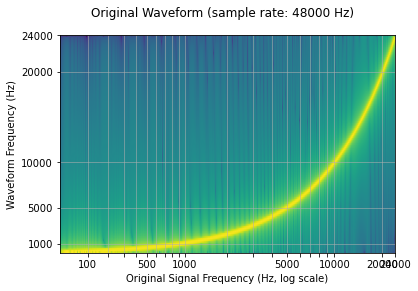

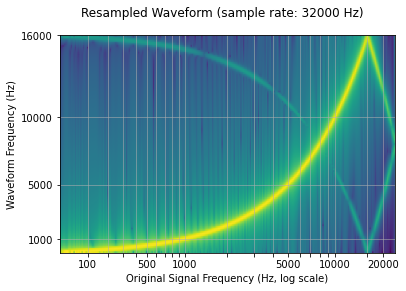

In [14]:
sample_rate = 48000
resample_rate = 32000

waveform = get_sine_sweep(sample_rate)
plot_sweep(waveform, sample_rate, title="Original Waveform")
play_audio(waveform, sample_rate)

resampler = T.Resample(sample_rate, resample_rate, dtype=waveform.dtype)
resampled_waveform = resampler(waveform)
plot_sweep(resampled_waveform, resample_rate, title="Resampled Waveform")
play_audio(waveform, sample_rate)

Audio Augmentation

In [2]:
import math
import os
import random

import matplotlib.pyplot as plt
import requests
from IPython.display import Audio, display

In [3]:
_SAMPLE_DIR = "_assets"
SAMPLE_RIR_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/room-response/rm1/impulse/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo.wav"  # noqa: E501
SAMPLE_RIR_PATH = os.path.join(_SAMPLE_DIR, "rir.wav")

SAMPLE_WAV_SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"  # noqa: E501
SAMPLE_WAV_SPEECH_PATH = os.path.join(_SAMPLE_DIR, "speech.wav")

SAMPLE_NOISE_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/distractors/rm1/babb/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo.wav"  # noqa: E501
SAMPLE_NOISE_PATH = os.path.join(_SAMPLE_DIR, "bg.wav")

os.makedirs(_SAMPLE_DIR, exist_ok=True)

In [4]:
def _fetch_data():
    uri = [
        (SAMPLE_RIR_URL, SAMPLE_RIR_PATH),
        (SAMPLE_WAV_SPEECH_URL, SAMPLE_WAV_SPEECH_PATH),
        (SAMPLE_NOISE_URL, SAMPLE_NOISE_PATH),
    ]
    for url, path in uri:
        with open(path, "wb") as file_:
            file_.write(requests.get(url).content)


_fetch_data()

In [5]:
def get_noise_sample(SAMPLE_NOISE_PATH, resample=None):
    return _get_sample(SAMPLE_NOISE_PATH, resample=resample)

def add_SNR(signal, sr, snr_db):
    global snr_noise  
    if snr_noise == None:
        noise, _ = get_noise_sample(resample=sr)
        noise = noise[:, : signal.shape[1]]
    
    speech_power = signal.norm(p=2)
    noise_power = noise.norm(p=2)

    snr = math.exp(snr_db / 10)
    scale = snr * noise_power / speech_power
    return (scale * signal + noise) / 2

In [6]:
def _get_sample(path):
    effects = [["remix", "1"]]
    if random.choice([True, False]):
        effects.append(["lowpass", "-1", "300"])
    if random.choice([True, False]):
        effects.append(["rate", "8000"])
    if random.choice([True, False]):
        effects.append(["speed", "0.8"])
    if random.choice([True, False]):
        effects.append(["reverb", "-w"])

    ad_signal, sr = torchaudio.sox_effects.apply_effects_file(path, effects=effects, normalize=False)
    if random.choice([True, False]):
        ad_signal = F.apply_codec(ad_signal, sr, {"format": "mp3", "compression": -9})
    if random.choice([True, False]):
        ad_signal = add_SNR(ad_signal, sr, 3)
    return ad_signal, sr


def get_sample(SAMPLE_WAV_PATH, resample=None):
    return _get_sample(SAMPLE_WAV_PATH, resample=resample)


def get_speech_sample(SAMPLE_WAV_SPEECH_PATH, resample=None):
    return _get_sample(SAMPLE_WAV_SPEECH_PATH, resample=resample)


def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)


def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    if sample_rate:
        print("Sample Rate:", sample_rate)
    print("Shape:", tuple(waveform.shape))
    print("Dtype:", waveform.dtype)
    print(f" - Max:     {waveform.max().item():6.3f}")
    print(f" - Min:     {waveform.min().item():6.3f}")
    print(f" - Mean:    {waveform.mean().item():6.3f}")
    print(f" - Std Dev: {waveform.std().item():6.3f}")
    print()
    print(waveform)
    print()


def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)


def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        return Audio(waveform[0], rate=sample_rate)
    elif num_channels == 2:
        return Audio((waveform[0], waveform[1]), rate=sample_rate)
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")


def get_rir_sample(SAMPLE_RIR_PATH, resample=None, processed=False):
    rir_raw, sample_rate = _get_sample(SAMPLE_RIR_PATH, resample=resample)
    if not processed:
        return rir_raw, sample_rate
    rir = rir_raw[:, int(sample_rate * 1.01) : int(sample_rate * 1.3)]
    rir = rir / torch.norm(rir, p=2)
    rir = torch.flip(rir, [1])
    return rir, sample_rate


def get_noise_sample(SAMPLE_NOISE_PATH, resample=None):
    return _get_sample(SAMPLE_NOISE_PATH, resample=resample)

In [7]:
def add_SNR(signal, sr, snr_db):
    global snr_noise  
    if snr_noise == None:
        noise, _ = get_noise_sample(resample=sr)
        noise = noise[:, : signal.shape[1]]
    
    speech_power = signal.norm(p=2)
    noise_power = noise.norm(p=2)

    snr = math.exp(snr_db / 10)
    scale = snr * noise_power / speech_power
    return (scale * signal + noise) / 2

In [12]:
torchaudio.set_audio_backend("sox")

RuntimeError: Backend "sox" is not one of available backends: ['soundfile'].

In [8]:
torchaudio.sox_effects.init_sox_effects()

RuntimeError: torchaudio.sox_effects.sox_effects.init_sox_effects requires sox

In [32]:
noisy_speech , sr = _get_sample('../data/spcup_2022_training_part1/0a1aa0cadc2173e7b0e8ed05d7f27c80.wav')
plot_waveform(noisy_speech, sample_rate, title=f"SNR")
plot_specgram(noisy_speech, sample_rate, title=f"SNR")

RuntimeError: torchaudio.sox_effects.sox_effects.apply_effects_file requires sox